In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

plt.style.use("seaborn-v0_8")


In [16]:
file_path = "mock_kaggle.csv"  
df = pd.read_csv(file_path)

print(df.head())
print(df.tail())
print(df.info())
print(df.describe())


         data  venda  estoque  preco
0  2014-01-01      0     4972   1.29
1  2014-01-02     70     4902   1.29
2  2014-01-03     59     4843   1.29
3  2014-01-04     93     4750   1.29
4  2014-01-05     96     4654   1.29
           data  venda  estoque  preco
932  2016-07-27     98     3179   2.39
933  2016-07-28    108     3071   2.39
934  2016-07-29    128     4095   2.39
935  2016-07-30    270     3825   2.39
936  2016-07-31    183     3642   2.39
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB
None
            venda      estoque       preco
count  937.000000   937.000000  937.000000
mean    90.533618  1608.258271    1.592572
std     80.6820

Date range: 2014-01-01 00:00:00 to 2016-07-31 00:00:00


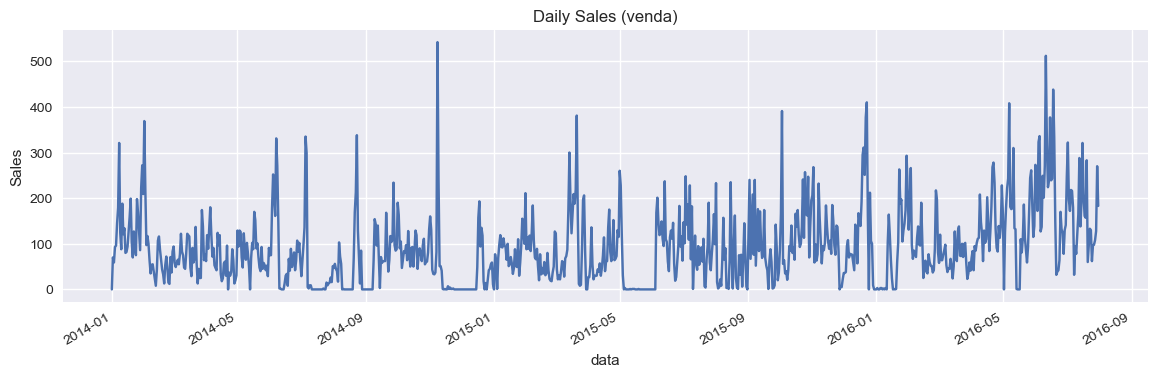

In [17]:
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values('data').reset_index(drop=True)

print("Date range:", df['data'].min(), "to", df['data'].max())

df = df.set_index('data')

df['venda'].plot(figsize=(14, 4), title="Daily Sales (venda)")
plt.ylabel("Sales")
plt.show()


In [18]:
df = df.asfreq('D')
print(df.isna().sum())
df['venda'] = df['venda'].fillna(0)
df['estoque'] = df['estoque'].interpolate()
df['preco'] = df['preco'].ffill()
print(df.isna().sum())


venda      6
estoque    6
preco      6
dtype: int64
venda      0
estoque    0
preco      0
dtype: int64


C:\Users\Ojas\AppData\Local\Temp\ipykernel_16056\3383142615.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['venda'].resample('M').sum()


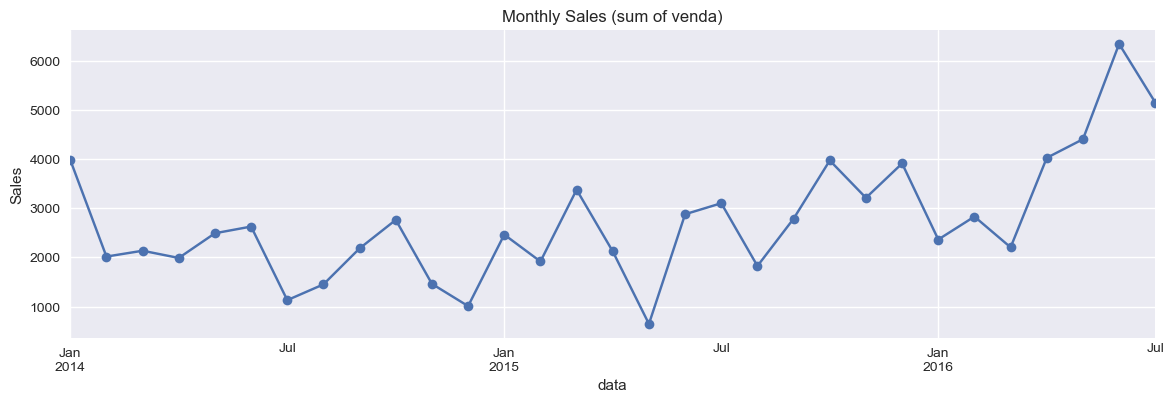

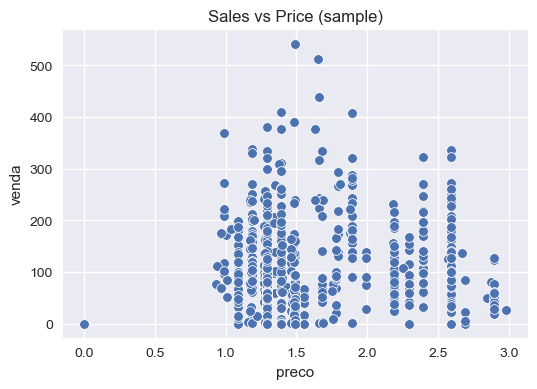

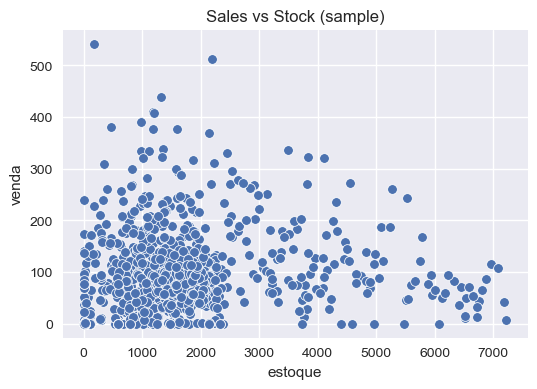

In [19]:
df['year'] = df.index.year
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek  # Monday=0

monthly_sales = df['venda'].resample('M').sum()

plt.figure(figsize=(14, 4))
monthly_sales.plot(marker='o', title="Monthly Sales (sum of venda)")
plt.ylabel("Sales")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x='preco', y='venda', data=df.sample(min(1000, len(df))))
plt.title("Sales vs Price (sample)")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x='estoque', y='venda', data=df.sample(min(1000, len(df))))
plt.title("Sales vs Stock (sample)")
plt.show()


In [20]:
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
df['weekofyear'] = df.index.isocalendar().week.astype(int)

df['venda_roll7_mean'] = df['venda'].rolling(window=7, min_periods=1).mean()
df['venda_roll30_mean'] = df['venda'].rolling(window=30, min_periods=1).mean()
df['venda_roll7_sum'] = df['venda'].rolling(window=7, min_periods=1).sum()

df['preco_lag1'] = df['preco'].shift(1)
df['preco_change'] = df['preco'] - df['preco_lag1']
df['is_promo'] = (df['preco'] < df['preco'].rolling(window=30, min_periods=1).median()).astype(int)

stock_threshold = df['estoque'].quantile(0.1)
df['low_stock_flag'] = (df['estoque'] < stock_threshold).astype(int)

df.head()


,venda,estoque,preco,year,month,dayofweek,is_weekend,weekofyear,venda_roll7_mean,venda_roll30_mean,venda_roll7_sum,preco_lag1,preco_change,is_promo,low_stock_flag
data,,,,,,,,,,,,,,,
2014-01-01,0.0,4972.0,1.29,2014,1,2,0,1,0.0,0.0,0.0,NaN,NaN,0,0
2014-01-02,70.0,4902.0,1.29,2014,1,3,0,1,35.0,35.0,70.0,1.29,0.0,0,0
2014-01-03,59.0,4843.0,1.29,2014,1,4,0,1,43.0,43.0,129.0,1.29,0.0,0,0
2014-01-04,93.0,4750.0,1.29,2014,1,5,1,1,55.5,55.5,222.0,1.29,0.0,0,0
2014-01-05,96.0,4654.0,1.29,2014,1,6,1,1,63.6,63.6,318.0,1.29,0.0,0,0


In [23]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add regressors
m.add_regressor('preco')
m.add_regressor('estoque')

# Fit on training data
m.fit(train_df[['ds', 'y', 'preco', 'estoque']])


21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = m.make_future_dataframe(periods=horizon)


future = future.merge(
    prophet_df[['ds', 'preco', 'estoque']],
    on='ds',
    how='left'
)

last_preco = prophet_df['preco'].iloc[-1]
last_estoque = prophet_df['estoque'].iloc[-1]

future['preco'] = future['preco'].fillna(last_preco)
future['estoque'] = future['estoque'].fillna(last_estoque)

future.tail()


,ds,preco,estoque
125,2022-05-06,149.5,302.0
126,2022-05-07,149.5,302.0
127,2022-05-08,149.5,302.0
128,2022-05-09,149.5,302.0
129,2022-05-10,149.5,302.0


In [29]:
forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
125,2022-05-06,125.000044,124.995808,125.004376
126,2022-05-07,126.000031,125.995595,126.004538
127,2022-05-08,127.000059,126.995464,127.004771
128,2022-05-09,128.000091,127.995331,128.005173
129,2022-05-10,129.000115,128.994954,129.005358


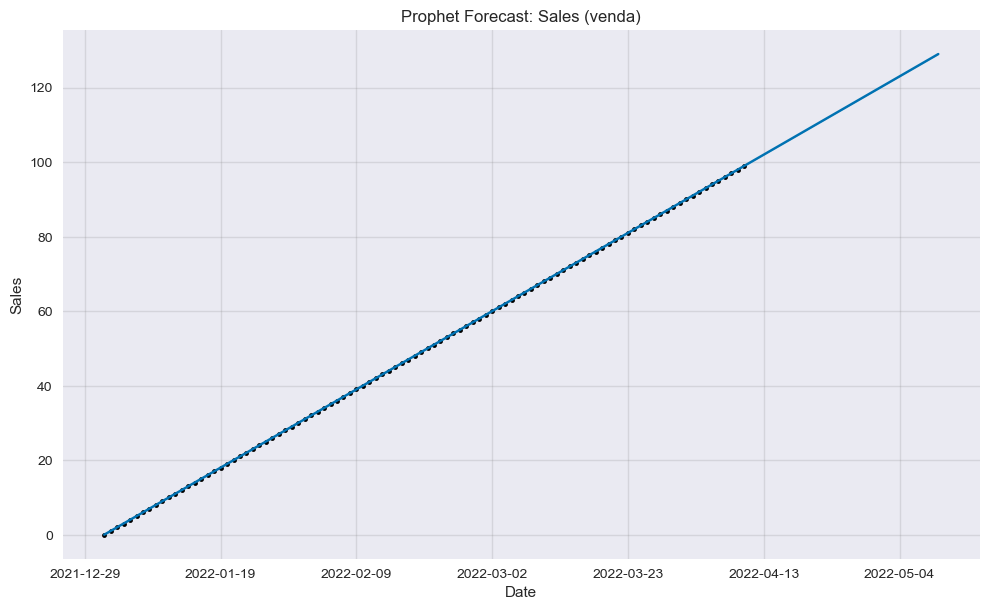

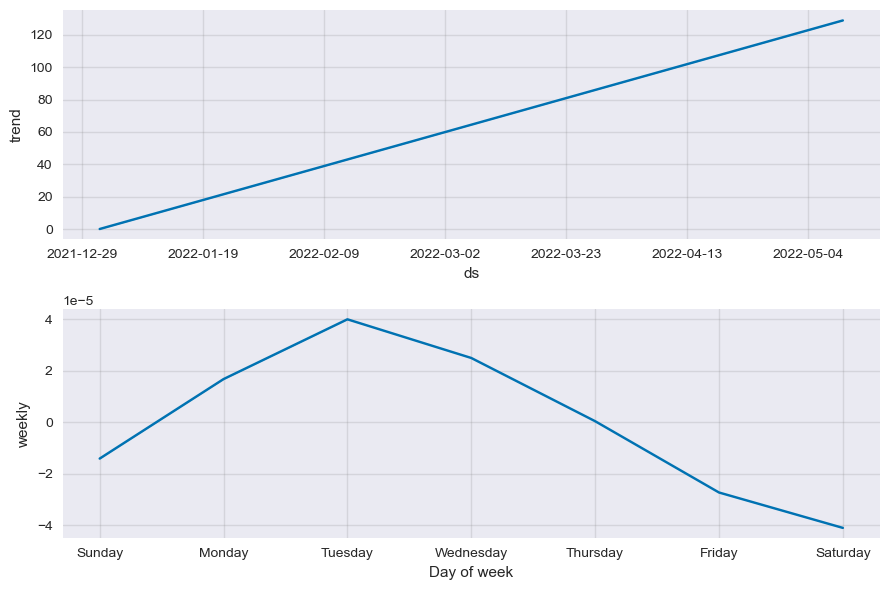

In [30]:
fig1 = m.plot(forecast)
plt.title("Prophet Forecast: Sales (venda)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

fig2 = m.plot_components(forecast)
plt.show()


Test MAE: 2.912040854133756e-05
Test RMSE: 3.6962710357399506e-05


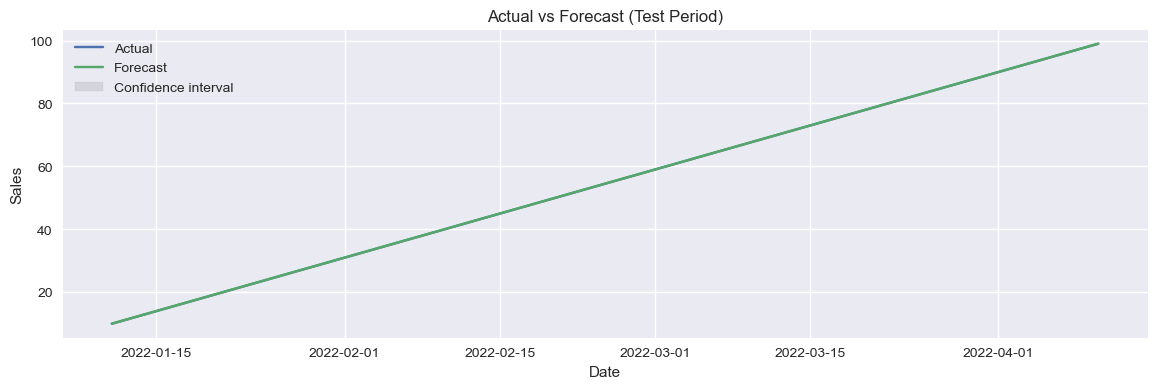

In [32]:
cutoff_date = prophet_df['ds'].max() - pd.DateOffset(months=3)  

test_df = prophet_df[prophet_df['ds'] > cutoff_date].copy()

result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    prophet_df[['ds', 'y']],
    on='ds',
    how='left'
)

result_test = result[result['ds'].isin(test_df['ds'])].copy()

mae = mean_absolute_error(result_test['y'], result_test['yhat'])
rmse = math.sqrt(mean_squared_error(result_test['y'], result_test['yhat']))

print("Test MAE:", mae)
print("Test RMSE:", rmse)

plt.figure(figsize=(14, 4))
plt.plot(result_test['ds'], result_test['y'], label='Actual')
plt.plot(result_test['ds'], result_test['yhat'], label='Forecast')
plt.fill_between(result_test['ds'], result_test['yhat_lower'], result_test['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence interval')
plt.legend()
plt.title("Actual vs Forecast (Test Period)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [33]:
full_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    prophet_df[['ds', 'y', 'preco', 'estoque']],
    on='ds',
    how='left'
)

full_result = full_result.rename(columns={
    'ds': 'date',
    'y': 'actual_venda',
    'yhat': 'forecast_venda'
})

last_actual_date = prophet_df['ds'].max()
full_result['is_forecast'] = (full_result['date'] > last_actual_date).astype(int)

full_result.head()


,date,forecast_venda,yhat_lower,yhat_upper,actual_venda,preco,estoque,is_forecast
0,2022-01-01,0.000211,-0.000936,0.001460,0.0,100.0,500.0,0
1,2022-01-02,1.000037,0.998851,1.001221,1.0,100.5,498.0,0
2,2022-01-03,1.999867,1.998602,2.001042,2.0,101.0,496.0,0
3,2022-01-04,2.999689,2.998496,3.000892,3.0,101.5,494.0,0
4,2022-01-05,3.999897,3.998846,4.001068,4.0,102.0,492.0,0


In [34]:
df_monthly = df[['venda']].copy()
df_monthly['date'] = df_monthly.index
df_monthly = df_monthly.set_index('date')

monthly = df_monthly['venda'].resample('M').sum().reset_index()
monthly.columns = ['date', 'monthly_sales']

monthly.head()


C:\Users\Ojas\AppData\Local\Temp\ipykernel_16056\1210255190.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_monthly['venda'].resample('M').sum().reset_index()


,date,monthly_sales
0,2014-01-31,3985.0
1,2014-02-28,2018.0
2,2014-03-31,2137.0
3,2014-04-30,1990.0
4,2014-05-31,2493.0


In [36]:
full_result.to_csv("sales_forecast_output.csv", index=False)
monthly.to_csv("sales_monthly.csv", index=False)

print("Exported: sales_forecast_output.csv and sales_monthly.csv")


Exported: sales_forecast_output.csv and sales_monthly.csv
